## Cardiac Regulatory Network for CMRG
### CRNC developed by Shulin Cao
### Only for use in CMRG

In [1]:
###------Network Simulator------###
###------Shulin Cao------###
###------CMRG, UC San Diego------###

###import packages###
import pandas as pd
import collections
import timeit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.mlab as mlab
import statistics
import random
import numpy.linalg
import numpy as np
import sys
from pyswarm import pso
from scipy.optimize import minimize
elapsed_time = timeit.default_timer()
from sklearn.linear_model import LinearRegression
from sklearn import cluster
import seaborn as sns
sns.set()
from sklearn import datasets
from sklearn.metrics import r2_score

In [2]:
def get_reactors(reac):
    reac_split = reac.split(' ')
    reactors = []
    for k in reac_split:
        if k != '&' and k!= '=>':
            reactors.append(k)
    return reactors[:-1]


def Hill(reactor, n, EC50):
    B = (EC50**n-1)/(2*EC50**n-1)
    C = (B-1)**(1/n)
    if reactor[0] == '!':
        return (1-B*globals()['{}'.format(reactor[1:])]**n/(C**n + globals()['{}'.format(reactor[1:])]**n))
    else:
        return B*globals()['{}'.format(reactor)]**n/(C**n + globals()['{}'.format(reactor)]**n)


def OR(reaction_list):
    tera = (-1)**(len(reaction_list)+1)
    for k in reaction_list:
        weight, n, EC50 = reaction_list[k]
        final = weight
        for j in get_reactors(k):
            final *= Hill(j, n, EC50)
        tera *= (final-1)
    tera +=1
    return tera

In [3]:
def inte(state,t,reaction_dict):
    for i in range(len(node_ID)):
        globals()['{}'.format(node_ID[i])] = state[i]
    for i in range(len(node_ID)):
        if len(reaction_dict[node_ID[i]]) == 1:
            reactors = get_reactors(list(reaction_dict[node_ID[i]].keys())[0])
            weight, n, EC50 = reaction_dict[node_ID[i]][list(reaction_dict[node_ID[i]].keys())[0]]
            TF = 1
            for j in reactors:
                TF *= Hill(j, n, EC50)
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*weight*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        else:
            TF = OR(reaction_dict[node_ID[i]])
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        #print(str(i)+' finished')
    return [globals()['{}'.format(k+ 'd')] for k in node_ID]

In [4]:
def hill_simulation( t, state0, reaction_dict):
    yHill_ss = odeint(inte, state0, t, args = (reaction_dict,))
    print('Hill Finished')
    return yHill_ss

In [5]:
###################-------------------------------###################
###################----------Loading Data---------###################
###################-------------------------------###################

macrophage = '/Users/mihir/Documents/Summer/Models/original_models/new_fibroblast.xlsx'

reactions = pd.read_excel(macrophage, sheet_name = 1, skiprows = 1, header = 0)
species = pd.read_excel(macrophage, sheet_name = 0, skiprows = 1, header = 0)
pmid = reactions['PMID'].tolist()
reactions = reactions[['Rule', 'Weight', 'n', 'EC50']]
species = species[['ID', 'Yinit', 'Ymax', 'tau']]
node_ID = species['ID'].tolist()
Yinit = species['Yinit'].tolist()
Ymax = species['Ymax'].tolist()
Ymax2 = species['Ymax'].tolist()
tau = species['tau'].tolist()

reaction_dict = collections.defaultdict(dict)
for k in range(len(reactions)):
    node = reactions.loc[k, 'Rule'].split(' ')
    reaction_dict[node[-1]][reactions.loc[k, 'Rule']] = reactions.loc[k, ['Weight', 'n', 'EC50']].tolist()


species_dict = dict()
for k in range(len(species)):
    #lis = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()
    species_dict[species.loc[k, 'ID']] = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()


y0_MA = []
y30m_MA = []
y30m_MA_trans = []
y4h_MA = []
y4h_MA_trans = []
for i in range(len(node_ID)):
    y0_MA.append(Yinit[i])
    y30m_MA.append(Yinit[i])
    y30m_MA_trans.append(Yinit[i])
    y4h_MA.append(Yinit[i])
    y4h_MA_trans.append(Yinit[i])

In [6]:
geneinput = {i:0 for i in node_ID[98:]}

In [7]:
for j in node_ID[98:]:
    for k in reaction_dict[j]:
        if '!' in k:
            geneinput[j] = 0.5
            break

In [8]:
a = []
b = []
for j in node_ID[98:]:
    a.append(j)
    b.append(geneinput[j])
ab = pd.DataFrame(data = {'Gene': a, 'Init':b})

In [9]:
ab.to_csv('./initial_ariel.csv', index = False)

### Step 1 Finalize the baseline

In [10]:
state0 = []
for k in range(len(node_ID)):
    state0.append(Yinit[k])  #solve_ivp

t = np.arange(0.0, 10, 0.01)
yHill_ss = hill_simulation(t, state0, reaction_dict)

/Users/mihir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Hill Finished


### Basic Plots

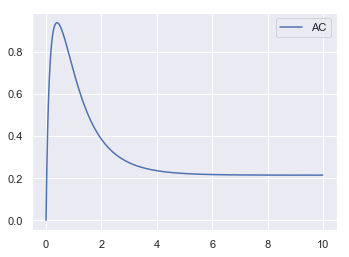

In [11]:
whatToDisplay = 1
k = 12000
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t[:k], yHill_ss[:k,whatToDisplay], label = node_ID[whatToDisplay])
plt.legend(loc='best')
plt.show()

### Contigency Tables

In [18]:
plt.scatter(np.log2(np.array(y4h_MA)[with_data]/np.array(y0_MA)[with_data]), np.log2(y240_MA[2399,with_data]/np.array(y0_MA)[with_data]))
plt.show()

NameError: name 'with_data' is not defined

In [19]:
y240_MA[2399,84:]

NameError: name 'y240_MA' is not defined

In [20]:
max(np.log2(y240_MA[2399,:]/np.array(y0_MA)))

NameError: name 'y240_MA' is not defined

In [21]:
contingency_table = []
for i in np.arange(0,9,0.01):
    mm = i
    c_1 = 0
    c_2 = 0
    c_3 = 0
    c_4 = 0
    c_5 = 0
    c_6 = 0
    c_7 = 0
    c_8 = 0
    c_9 = 0
    for i in with_data:
        new_gene = node_ID[i][5:]
        if list(RNA_raw[RNA_raw['Symbol'] == new_gene]['q_value.3'])[0]>alpha:
            if np.log2(y240_MA[2399,i]/np.array(y0_MA)[i])>=mm:
                c_2 += 1
            elif np.log2(y240_MA[2399,i]/np.array(y0_MA)[i])<=-mm:
                c_8 += 1
            else:
                c_5 += 1
        else:
            if (RNA_raw[RNA_raw['Symbol'] == new_gene]['4h_Long_Avg']>=y0_MA[i]).bool() and np.log2(y240_MA[2399,i]/np.array(y0_MA)[i])>=mm:
                c_1 += 1
            elif (RNA_raw[RNA_raw['Symbol'] == new_gene]['4h_Long_Avg']<=y0_MA[i]).bool() and np.log2(y240_MA[2399,i]/np.array(y0_MA)[i])>=mm:
                c_3 += 1
            elif (RNA_raw[RNA_raw['Symbol'] == new_gene]['4h_Long_Avg']>=y0_MA[i]).bool() and np.log2(y240_MA[2399,i]/np.array(y0_MA)[i])<=-mm:
                c_7 += 1
            elif (RNA_raw[RNA_raw['Symbol'] == new_gene]['4h_Long_Avg']<=y0_MA[i]).bool() and np.log2(y240_MA[2399,i]/np.array(y0_MA)[i])<=-mm:
                c_9 += 1
            elif (RNA_raw[RNA_raw['Symbol'] == new_gene]['4h_Long_Avg']>=y0_MA[i]).bool() and abs(np.log2(y240_MA[2399,i]/np.array(y0_MA)[i]))<mm:
                c_4 += 1
            else:
                c_6 += 1
    contingency_table.append([c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9])

NameError: name 'with_data' is not defined

In [22]:
tpr = []
fpr = []
for i in contingency_table:
    tp = i[0]+i[2]+i[6]+i[8]
    fp = i[1]+i[7]
    fn = i[3]+i[5]
    tn = i[4]
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))

NameError: name 'fpr_all' is not defined

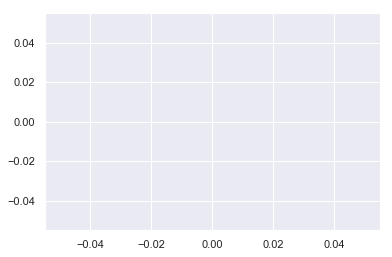

In [23]:
plt.plot(fpr, tpr, label = 'on DEG')
plt.plot(fpr_all, tpr_all, label = 'on All Genes')
plt.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01), label = 'Unity Line')
plt.legend(loc='best')
plt.show()

In [24]:
contingency_table[0]

IndexError: list index out of range

## DEGenes

In [31]:
DEG = []
for i in range(len(node_ID)):
    if node_ID[i][5:] in RNA_symbols and RNA[RNA['Symbol']==node_ID[i][5:]]['DE?'].bool()==True:
        DEG.append(i)

In [32]:
for i in DEG:
    if abs(y240_MA[2399,i]-y4h_MA[i])/y4h_MA[i] <= 0.1:
        print(i, node_ID[i])

85 gene_6430548M08Rik
108 gene_Amotl2
210 gene_Crim1
215 gene_Csrp3
289 gene_Fosb
291 gene_Fosl2
367 gene_Jun
414 gene_Map2k3
416 gene_Mapk6
480 gene_Nptx1
618 gene_Sntb1
633 gene_Srm
662 gene_Tgfb3
688 gene_Trim54
723 gene_Zfp36


## Fig S3
### 210, 480, 487 can be used for demo

In [33]:
i = 414
print(node_ID[i], y240_MA[2399,i]/y0_MA[i], y4h_MA[i]/y0_MA[i])
print(node_ID[i], y240_MA[299,i]/y0_MA[i], y30m_MA[i]/y0_MA[i])

gene_Map2k3 1.4865638375744814 1.6468506268776002
gene_Map2k3 1.0741936887393675 1.2461877136271846


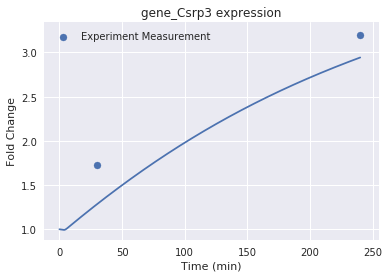

In [35]:
plt.plot(t_MA[:2400], y240_MA[:2400,215]/y0_MA[215])
plt.scatter([30,240], [y30m_MA[215]/y0_MA[215], y4h_MA[215]/y0_MA[215]], label = 'Experiment Measurement')
plt.legend(loc = 'best')
plt.title(node_ID[215] + ' expression')
plt.xlabel('Time (min)')
plt.ylabel('Fold Change')
plt.show()

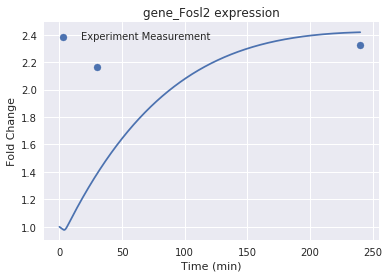

In [36]:
plt.plot(t_MA[:2400], y240_MA[:2400,291]/y0_MA[291])
plt.scatter([30,240], [y30m_MA[291]/y0_MA[291], y4h_MA[291]/y0_MA[291]], label = 'Experiment Measurement')
plt.legend(loc = 'best')
plt.title(node_ID[291] + ' expression')
plt.xlabel('Time (min)')
plt.ylabel('Fold Change')
plt.show()

## Fig7 sensitivity analysis

In [25]:
def get_relation(reac):
    split_reac = reac.split(' ')
    if len(split_reac) ==2:
        return ['Input', split_reac[1]]
    else:
        reactor = []
        for k in split_reac[:-2]:
            if k!= '&':
                reactor.append(getout_inhib(k))
        return [reactor, split_reac[-1]]
def getout_inhib(node):
    if node[0] == '!':
        return node[1:]
    else:
        return node

In [26]:
rules = reactions['rule'].tolist()
relationship = []
for k in rules:
    if get_relation(k)[0] == 'Input':
        relationship.append(tuple(get_relation(k)+[node_ID.index(get_relation(k)[1])]))
    else:
        for i in get_relation(k)[0]:
            relationship.append((i, get_relation(k)[1], node_ID.index(get_relation(k)[1])))
xxx = pd.DataFrame(columns = ['Start', 'End', 'End_Index'])
for i in relationship:
    xxx.loc[len(xxx)] = list(i)
revi_xxx = xxx.loc[xxx['End_Index'].isin(with_data)]
transcription_factors = ['CREB', 'NFkB', 'NFAT', 'GATA4', 'MEF2', 'cFos', 'cJun', 'cMyc', 'SRF', 'FoxO', 'STAT']

KeyError: 'rule'

In [27]:
short_expression = pd.DataFrame(columns=['30min', '1h', '2h', '4h'])

In [28]:
short_expression['30min'] = y240_MA[299, with_data]
short_expression['1h'] = y240_MA[599, with_data]
short_expression['2h'] = y240_MA[1199, with_data]
short_expression['4h'] = y240_MA[2399, with_data]

NameError: name 'y240_MA' is not defined

In [29]:
short_expression.index = with_data

NameError: name 'with_data' is not defined

In [30]:
kmeans2 = cluster.KMeans(n_clusters=11, n_init=200).fit(np.log2(short_expression))
X2 = kmeans2.labels_

ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required.

In [31]:
Cluster_res2 = collections.defaultdict(list)
for i in range(len(X2)):
    Cluster_res2[X2[i]].append(with_data[i])

clus_com2 = collections.defaultdict(list)
for j in transcription_factors:
    a_tra = set(revi_xxx[revi_xxx['Start'] == j]['End_Index'].tolist())
    for i in range(11):
        clus_com2[j].append(len(set(Cluster_res2[i]).intersection(a_tra))/len(a_tra))

re_clus2 = pd.DataFrame(columns = transcription_factors)
for k in transcription_factors:
    re_clus2[k] = clus_com2[k]

NameError: name 'X2' is not defined

In [32]:
ax_plot = sns.heatmap(re_clus2, cmap="Blues")
plt.yticks(rotation=1) 
ax_plot.invert_yaxis()
ax_plot.set(ylabel='Cluster Centroid', xlabel='Transcription Factors')

NameError: name 're_clus2' is not defined